# Importing

In [26]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
import pandas as pd


columns = [
    "Overall Qual",
    "Overall Cond",
    "Gr Liv Area",
    "Central Air",
    "Total Bsmt SF",
    "SalePrice",
]

df = pd.read_csv(
    "http://jse.amstat.org/v19n3/decock/AmesHousing.txt", sep="\t", usecols=columns
)

df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [3]:
df["Central Air"] = df["Central Air"].map({"Y": 1, "N": 0})

df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [4]:
df = df.dropna(axis=0)
print(df.isnull().sum())

df.head()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64


,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,1,1656,215000
1,5,6,882.0,1,896,105000
2,6,6,1329.0,1,1329,172000
3,7,5,2110.0,1,2110,244000
4,5,5,928.0,1,1629,189900


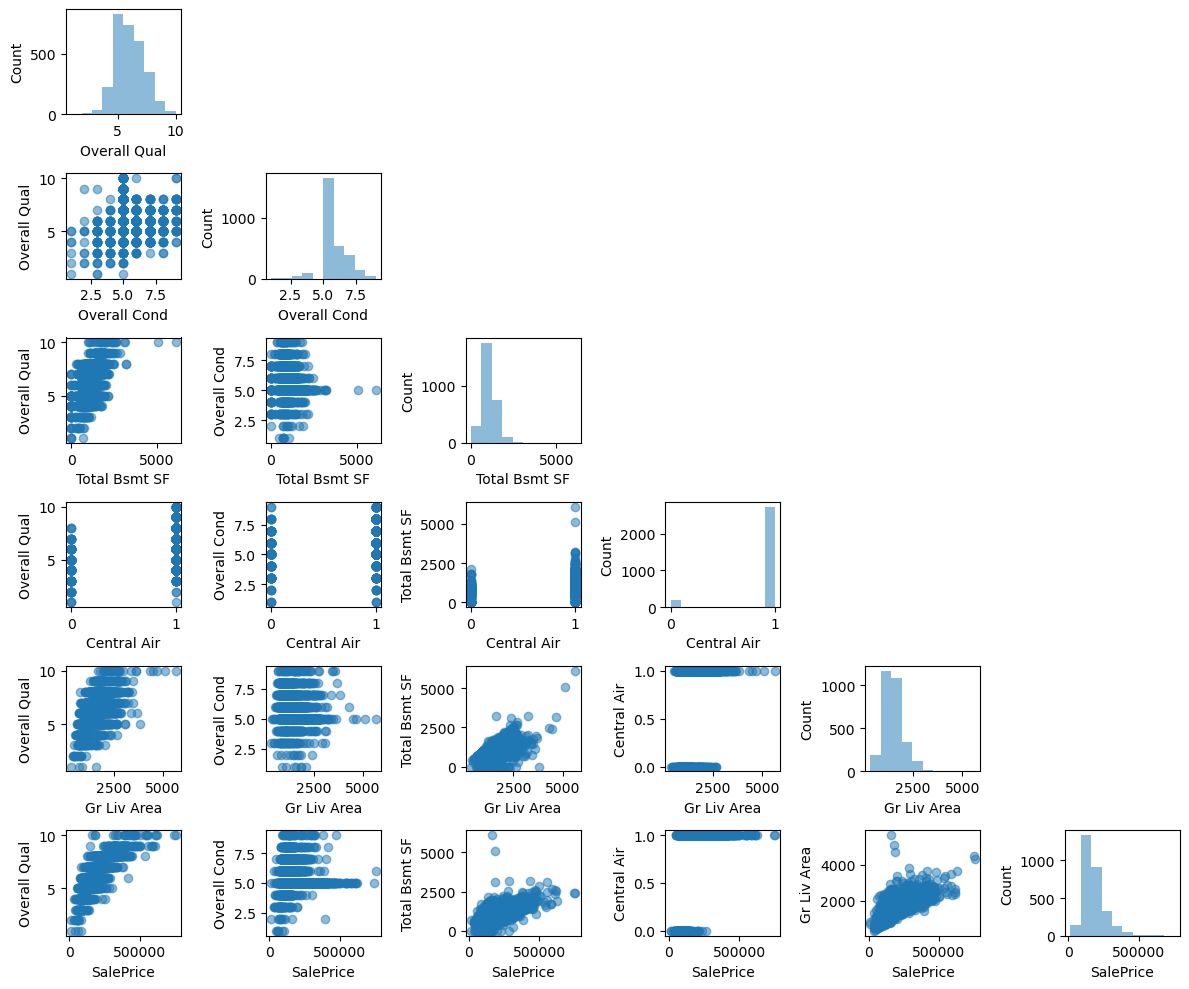

In [5]:
scatterplotmatrix(df.values, figsize=(12, 10), names=df.columns, alpha=0.5)
plt.tight_layout()
plt.show()

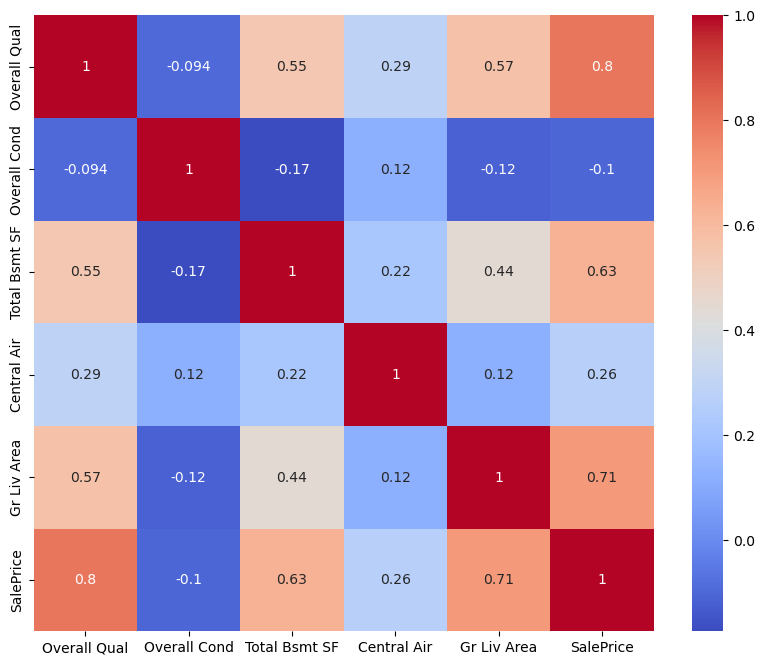

In [6]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

## Linear Regression function

In [7]:
class LinearRegressionGD:
    def __init__(self, eta=0.1, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, x, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.1, size=x.shape[1])
        self.b_ = np.array([0.0])
        self.losses_ = []

        for i in range(self.n_iter):
            output = self.net_input(x)
            errors = y - output
            self.w_ += self.eta * 2.0 * x.T.dot(errors) / x.shape[0]
            self.b_ = self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, x):
        return np.dot(x, self.w_) + self.b_

    def predict(self, x):
        return self.net_input(x)

In [8]:
X = df[["Gr Liv Area"]].values
y = df["SalePrice"].values

from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [9]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

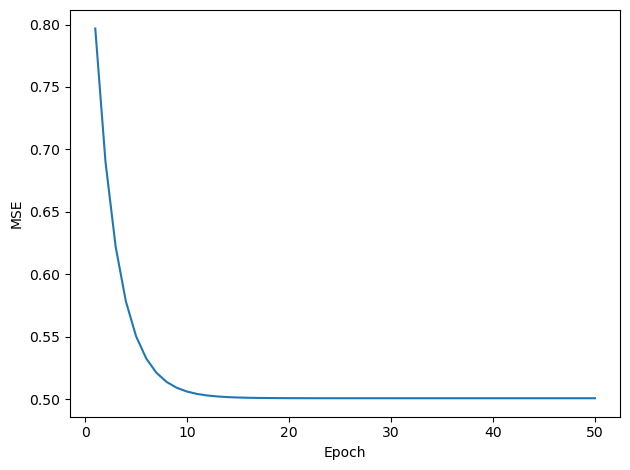

In [10]:
plt.plot(range(1, lr.n_iter + 1), lr.losses_)
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

In [11]:
def lin_regplot(x, y, model):
    plt.scatter(x, y, c="steelblue", edgecolor="white", s=70, alpha=0.75)
    plt.plot(x, model.predict(x), color="black", lw=2)
    return

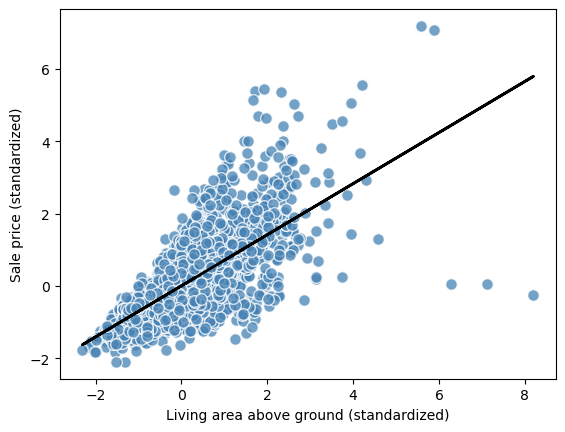

In [12]:
lin_regplot(X_std, y_std, lr)
plt.xlabel("Living area above ground (standardized)")
plt.ylabel("Sale price (standardized)")
plt.show()

In [13]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f"Sale price: ${target_reverted.flatten()[0]:.2f}")

Sale price: $292507.40


In [14]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)

print(f"Slope: {slr.coef_[0].round(3)}")
print(f"Intercept: {slr.intercept_.round(3)}")

Slope: 111.666
Intercept: 13342.979


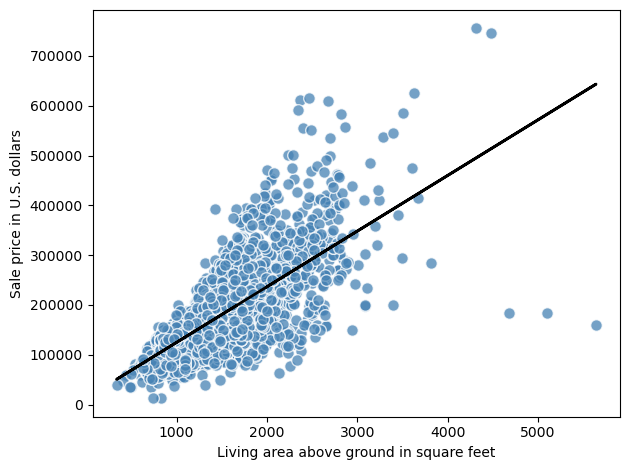

In [15]:
lin_regplot(X, y, slr)
plt.xlabel("Living area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")
plt.tight_layout()
plt.show()

## RANSAC

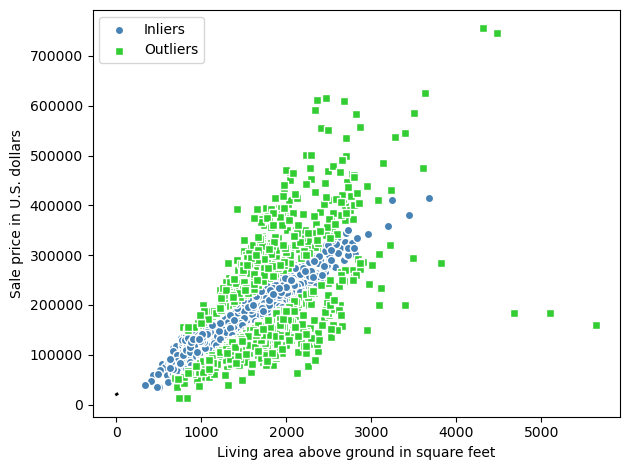

Slope: 106.348
Intercept: 20190.093


In [16]:
ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100,
    min_samples=0.95,
    loss="absolute_error",  # default,
    residual_threshold=None,
    random_state=123,
)

ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
# plot inliers
plt.scatter(
    X[inlier_mask],
    y[inlier_mask],
    c="steelblue",
    edgecolor="white",
    marker="o",
    label="Inliers",
)
# plot outliers
plt.scatter(
    X[outlier_mask],
    y[outlier_mask],
    c="limegreen",
    edgecolor="white",
    marker="s",
    label="Outliers",
)

plt.plot(line_X, line_y_ransac, color="black", lw=2)
plt.xlabel("Living area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()
print(f"Slope: {ransac.estimator_.coef_[0]:.3f}")
print(f"Intercept: {ransac.estimator_.intercept_:.3f}")

In [17]:
def median_abs_deviation(data):
    return np.median(np.abs(data - np.median(data)))


median_abs_deviation(y)

37000.0

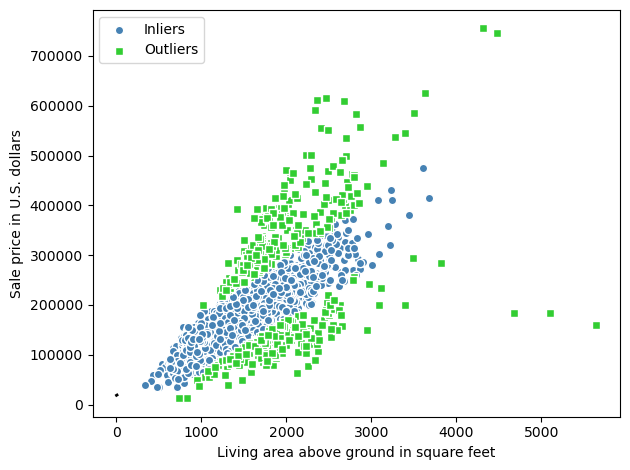

In [18]:
# MODEL WITH HIGHER RESIDUAL THRESHOLD
ransac = RANSACRegressor(
    LinearRegression(),
    max_trials=100,  # default
    min_samples=0.95,
    loss="absolute_error",  # default
    residual_threshold=65000,  # default
    random_state=123,
)

ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(
    X[inlier_mask],
    y[inlier_mask],
    c="steelblue",
    edgecolor="white",
    marker="o",
    label="Inliers",
)
plt.scatter(
    X[outlier_mask],
    y[outlier_mask],
    c="limegreen",
    edgecolor="white",
    marker="s",
    label="Outliers",
)
plt.plot(line_X, line_y_ransac, color="black", lw=2)
plt.xlabel("Living area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")
plt.legend(loc="upper left")

plt.tight_layout()
# plt.savefig('figures/09_10.png', dpi=300)
plt.show()

# Evaluating the performance of linear regression models

In [19]:
target = "SalePrice"
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

In [20]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

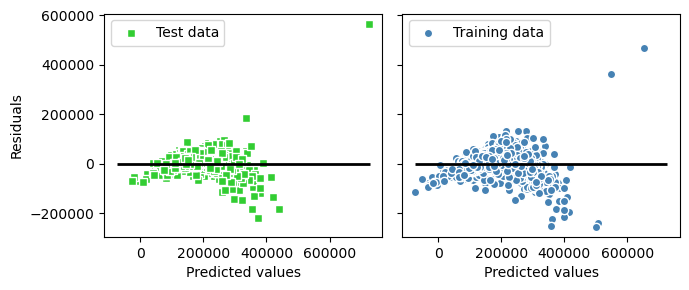

In [21]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(
    y_test_pred,
    y_test_pred - y_test,
    c="limegreen",
    marker="s",
    edgecolor="white",
    label="Test data",
)
ax2.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c="steelblue",
    marker="o",
    edgecolor="white",
    label="Training data",
)
ax1.set_ylabel("Residuals")

for ax in (ax1, ax2):
    ax.set_xlabel("Predicted values")
    ax.legend(loc="upper left")
    ax.hlines(y=0, xmin=x_min - 100, xmax=x_max + 100, color="black", lw=2)

plt.tight_layout()

# plt.savefig('figures/09_11.png', dpi=300)
plt.show()

## MSE

In [22]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"MSE train: {mse_train:.2f}")
print(f"MSE test: {mse_test:.2f}")

MSE train: 1497216245.85
MSE test: 1516565821.00


## MAE

In [23]:
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE train: {mae_train:.2f}")
print(f"MAE test: {mae_test:.2f}")

MAE train: 25983.03
MAE test: 24921.29


## R^2

In [24]:
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"R^2 train: {r2_train:.2f}")
print(f"R^2 test: {r2_test:.2f}")

R^2 train: 0.77
R^2 test: 0.75


# Regularized methods

In [28]:
# Ridge
ridge = Ridge(alpha=1.0)

# Lasso
lasso = Lasso(alpha=1.0)

# ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

"""
These methods are used like a normal lr model with .fit, and .predict attributes
"""

'\nThese methods are used like a normal lr model with .fit, and .predict attributes\n'

# Polynomial Regression

Text(0, 0.5, 'y')

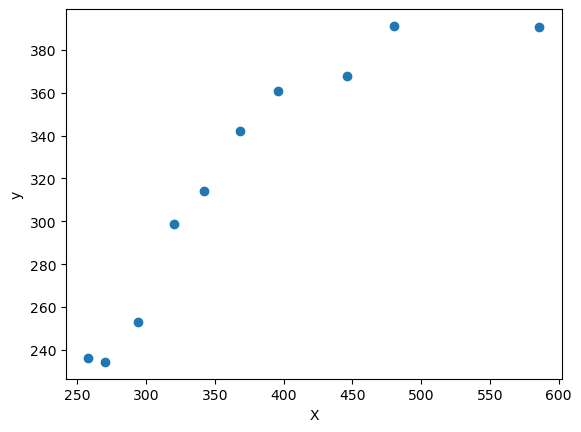

In [31]:
X = np.array([258.0, 270.0, 294.0, 320.0, 342.0, 368.0, 396.0, 446.0, 480.0, 586.0])[
    :, np.newaxis
]

y = np.array([236.4, 234.4, 252.8, 298.6, 314.2, 342.2, 360.8, 368.0, 391.2, 390.8])

plt.scatter(X, y)
plt.xlabel("X")
plt.ylabel("y")

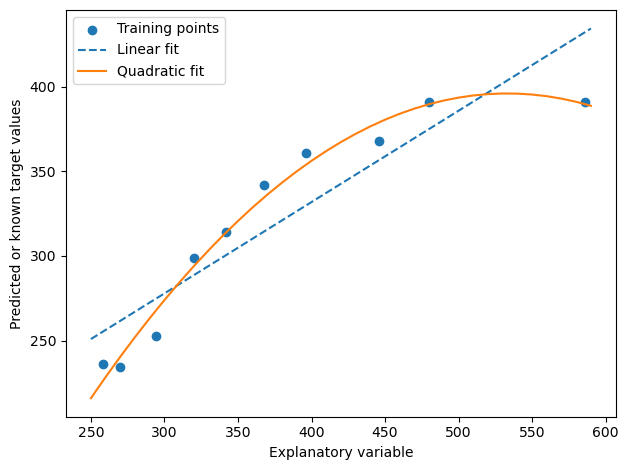

In [37]:
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)  # Scaler function
X_quad = quadratic.fit_transform(X)

# fitting linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[
    :, np.newaxis
]  # Generate new x values from 250 - 600 stepping by 10, and reshape it for the lr.fit function
y_lin_fit = lr.predict(X_fit)

# Fitting quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(
    quadratic.fit_transform(X_fit)
)  # uses the randomly generated points to create the quadratic (curved) line

# plot
plt.scatter(X, y, label="Training points")
plt.plot(X_fit, y_lin_fit, label="Linear fit", linestyle="--")
plt.plot(X_fit, y_quad_fit, label="Quadratic fit")
plt.xlabel("Explanatory variable")
plt.ylabel("Predicted or known target values")
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

In [39]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)  # Quad transformed has to be used with pr function

mse_lin = mean_squared_error(y, y_lin_pred)
mse_quad = mean_squared_error(y, y_quad_pred)

print(f"Training MSE linear: {mse_lin:.3f}" f", quadratic: {mse_quad:.3f}")

r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)
print(f"Training R^2 linear: {r2_lin:.3f}" f", quadratic: {r2_quad:.3f}")

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


See https://github.com/rasbt/machine-learning-book/blob/main/ch09/ch09.ipynb for an example of cubic and quadratic regression with the Ames housing dataset

# Decision Tree regression

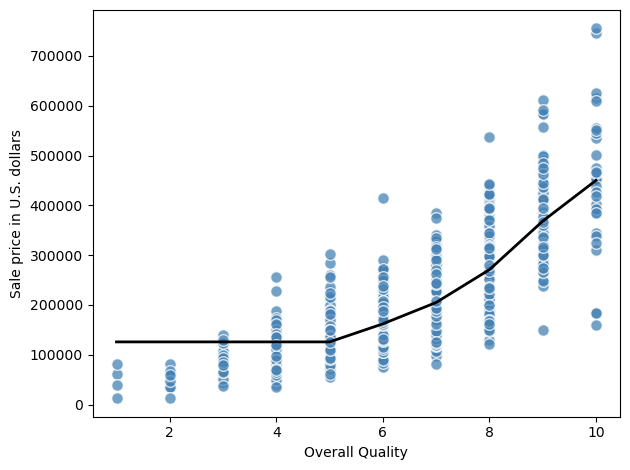

In [46]:
X = df[["Overall Qual"]].values
y = df["SalePrice"].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel("Overall Quality")
plt.ylabel("Sale price in U.S. dollars")
plt.tight_layout()
plt.show()

In [47]:
tree_r2 = r2_score(y, tree.predict(X))
tree_r2

0.6852365179472769

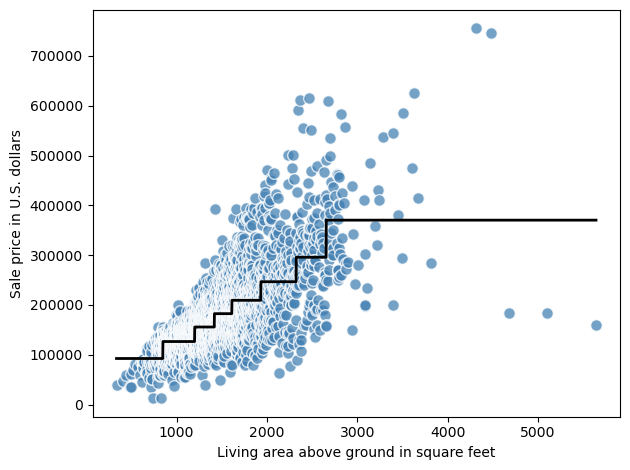

In [48]:
X = df[["Gr Liv Area"]].values
y = df["SalePrice"].values


tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel("Living area above ground in square feet")
plt.ylabel("Sale price in U.S. dollars")

plt.tight_layout()
# plt.savefig('figures/09_15.png', dpi=300)
plt.show()

In [49]:
tree_r2 = r2_score(y, tree.predict(X))
tree_r2

0.5144569334885711

# Random Forest Regression

In [50]:
target = "SalePrice"
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

In [54]:
forest = RandomForestRegressor(
    n_estimators=1000, criterion="squared_error", random_state=1, n_jobs=1
)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)


mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE train: {mae_train:.2f}")
print(f"MAE test: {mae_test:.2f}")


r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f"R^2 train: {r2_train:.2f}")
print(f"R^2 test: {r2_test:.2f}")

MAE train: 8305.18
MAE test: 20821.77
R^2 train: 0.98
R^2 test: 0.85


## Residuals of the models

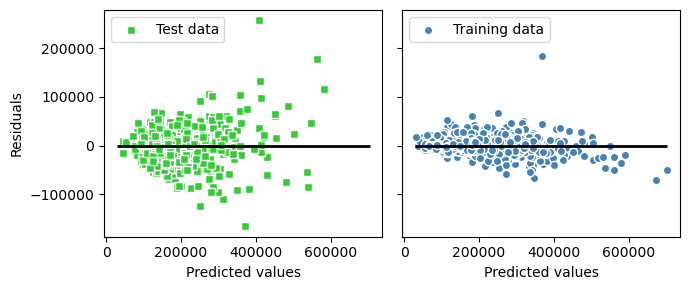

In [55]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(
    y_test_pred,
    y_test_pred - y_test,
    c="limegreen",
    marker="s",
    edgecolor="white",
    label="Test data",
)
ax2.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c="steelblue",
    marker="o",
    edgecolor="white",
    label="Training data",
)
ax1.set_ylabel("Residuals")

for ax in (ax1, ax2):
    ax.set_xlabel("Predicted values")
    ax.legend(loc="upper left")
    ax.hlines(y=0, xmin=x_min - 100, xmax=x_max + 100, color="black", lw=2)

plt.tight_layout()

# plt.savefig('figures/09_16.png', dpi=300)
plt.show()